# Indiana Pines

1. Import dependencies

In [1]:
import random
import torch
import multiprocessing
import numpy as np

import torch.utils.data as data

from sklearn.model_selection import train_test_split

from lightning import Trainer

from src.util.torch_device import resolve_torch_device
from src.util.patches import extract_patches, scale_patched
from src.data.indian_pines import load_indian_pines
from src.model.hsic import HyperSpectralImageClassifier
from src.model.fully_convolutional_lenet import FullyConvolutionalLeNet
from src.visualization.plot import plot_segmentation_comparison

2. Prepare env

In [2]:
random_seed = 42

random.seed(random_seed)
torch.manual_seed(random_seed)
np.random.seed(random_seed)

batch_size = 32
patch_size = 9
num_epochs = 12
learning_rate = 1e-3

device = resolve_torch_device()

In [3]:
f"Device is {device}"

'Device is mps'

3. Load dataset

In [4]:
image, labels = load_indian_pines()

image_h = image.shape[0]
image_w = image.shape[1]
image_c = image.shape[2]

In [5]:
x, y = extract_patches(image, labels, patch_size=patch_size)

In [6]:
scale, x = scale_patched(x)

In [7]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=random_seed, stratify=y
)

In [8]:
x_tensor = torch.tensor(x, dtype=torch.float32).permute(0, 3, 1, 2) 
x_train_tensor = torch.tensor(x_train, dtype=torch.float32).permute(0, 3, 1, 2)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32).permute(0, 3, 1, 2)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

In [9]:
cpu_count = multiprocessing.cpu_count()

f"Setting num_workers to {cpu_count}"

'Setting num_workers to 14'

In [10]:
train_dataset = data.TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = data.TensorDataset(x_test_tensor, y_test_tensor)

train_loader = data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=cpu_count,
    persistent_workers=True,
)
test_loader = data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=cpu_count,
    persistent_workers=True,
)

In [11]:
f"Training samples: {len(train_dataset)}, Testing samples: {len(test_dataset)}"

'Training samples: 16820, Testing samples: 4205'

In [12]:
num_classes = len(np.unique(y))

f"Number of classes {num_classes}"

'Number of classes 17'

4. Train model

In [13]:
model = HyperSpectralImageClassifier(
    FullyConvolutionalLeNet(image_c, num_classes), num_classes, lr=learning_rate
)

trainer = Trainer(accelerator="auto", devices=1, max_epochs=num_epochs)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/alexandermelashchenko/Workspace/spatial-regulated-self-training/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


In [14]:
trainer.fit(model, train_loader, test_loader)


  | Name             | Type                    | Params | Mode 
---------------------------------------------------------------------
0 | net              | FullyConvolutionalLeNet | 509 K  | train
1 | f1               | MulticlassF1Score       | 0      | train
2 | overall_accuracy | MulticlassAccuracy      | 0      | train
3 | average_accuracy | MulticlassAccuracy      | 0      | train
4 | kappa            | MulticlassCohenKappa    | 0      | train
---------------------------------------------------------------------
509 K     Trainable params
0         Non-trainable params
509 K     Total params
2.040     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=12` reached.


5. Display prediction

In [15]:
y_pred = model(x_tensor)
y_pred = torch.argmax(y_pred, dim=1)
y_pred = y_pred.reshape(image_h, image_w)

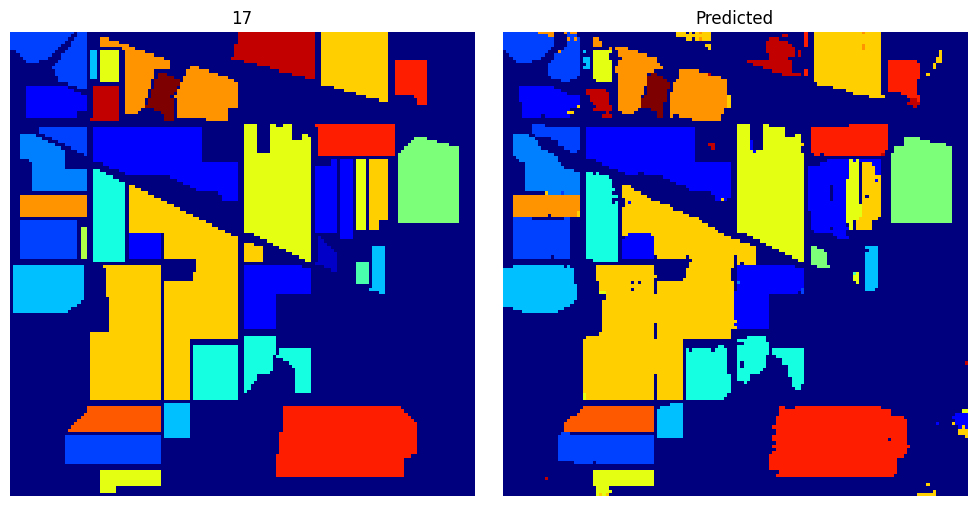

In [16]:
plot_segmentation_comparison(y.reshape(image_h, image_w), y_pred.numpy(), num_classes)